# Word2Vec (Negative Sampling)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
np.__version__, torch.__version__

('2.0.2', '2.6.0+cu124')

In [ ]:
import matplotlib
matplotlib.__version__

'3.10.0'

## 1. Load data

In [ ]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", "grape apple apple",
        "dog cat animal", "cat dog animal", "cat animal dog", "fish dog dog"]

In [ ]:
#1. tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['grape', 'apple', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog'],
 ['fish', 'dog', 'dog']]

In [ ]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [ ]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['dog']

7

In [ ]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [ ]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'grape'

## 2. Prepare train data

In [ ]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2

    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)

    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])

    return np.array(inputs), np.array(labels)

x, y = random_batch(4, corpus)

In [ ]:
x.shape  #batch_size, 1

(4, 1)

In [ ]:
x

array([[6],
       [1],
       [1],
       [7]])

In [ ]:
y.shape  #batch_size 1

(4, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

if i trake 10 positive samples, i would take k*10, 40 or 50 negative samples, why? to give me more evidence

also, it can happen that some of the positive samples can come, because i am sampling for distribution, we can have chceks to consider these cenarios, it is always safe to consider more negative examples.

In [1]:
z = 0.001

In [ ]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

24

In [ ]:
vocabs

['animal', 'apple', 'banana', 'fish', 'fruit', 'grape', 'cat', 'dog', '<UNK>']

$$P(w)=U(w)^{3/4}/Z$$

In [ ]:

#**.75 so there is a better chance to get the lower terms.
# they found that sampling directly from the unigram distribution gives too many common words (like "the", "is", "and").
# This:

# Flattens the distribution.

# Downsamples very frequent words.

# Gives more chance to less frequent, but still meaningful, words.


unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)

Counter(unigram_table)

Counter({'animal': 210,
         'apple': 308,
         'banana': 210,
         'fish': 92,
         'fruit': 210,
         'grape': 92,
         'cat': 210,
         'dog': 308})

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [ ]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [ ]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))

    return torch.cat(neg_samples) #batch_size, k

In [ ]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [ ]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [ ]:
y_tensor[1]

tensor([2])

In [ ]:
neg_samples[1]

tensor([7, 7, 4, 4, 7])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [ ]:
class SkipgramNeg(nn.Module):

    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()

    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)

        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)

        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)

        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)

        return -torch.mean(loss)

In [ ]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [ ]:
loss = model(x_tensor, y_tensor, neg_samples)

In [ ]:
loss

tensor(1.3344, grad_fn=<NegBackward0>)

## 5. Training

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 100000

for epoch in range(num_epochs):

    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)

    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)

    #backprogate
    optimizer.zero_grad()
    loss.backward()

    #update alpha
    optimizer.step()

    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 1.966974
Epoch   2000 | Loss: 1.066401
Epoch   3000 | Loss: 1.030701
Epoch   4000 | Loss: 0.718809
Epoch   5000 | Loss: 0.537171
Epoch   6000 | Loss: 0.742791
Epoch   7000 | Loss: 0.410865
Epoch   8000 | Loss: 0.751096
Epoch   9000 | Loss: 0.380179
Epoch  10000 | Loss: 0.493725
Epoch  11000 | Loss: 0.220913
Epoch  12000 | Loss: 0.255820
Epoch  13000 | Loss: 0.375722
Epoch  14000 | Loss: 0.264235
Epoch  15000 | Loss: 0.303288
Epoch  16000 | Loss: 0.127462
Epoch  17000 | Loss: 0.182745
Epoch  18000 | Loss: 0.212843
Epoch  19000 | Loss: 0.173767
Epoch  20000 | Loss: 0.131613
Epoch  21000 | Loss: 0.157388
Epoch  22000 | Loss: 0.395075
Epoch  23000 | Loss: 0.140271
Epoch  24000 | Loss: 0.096526
Epoch  25000 | Loss: 0.126204
Epoch  26000 | Loss: 0.107892
Epoch  27000 | Loss: 0.081271
Epoch  28000 | Loss: 0.098185
Epoch  29000 | Loss: 0.089387
Epoch  30000 | Loss: 0.134538
Epoch  31000 | Loss: 0.076046
Epoch  32000 | Loss: 0.051511
Epoch  33000 | Loss: 0.103385
Epoch  340

## 6. Plot the embeddings

In [ ]:
vocabs

['fish', 'fruit', 'dog', 'cat', 'grape', 'animal', 'apple', 'banana', '<UNK>']

In [ ]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([7])

In [ ]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[ 2.4688, -2.3836]], grad_fn=<DivBackward0>)

In [ ]:
banana_embed_o

tensor([[ 4.4068, -0.1218]], grad_fn=<EmbeddingBackward0>)

In [ ]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']

    word = torch.LongTensor([word2index[word]])

    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2

    return embed[0][0].item(), embed[0][1].item()

In [ ]:
get_embed('fruit')

(2.7261922359466553, -2.8429956436157227)

In [ ]:
get_embed('cat')

(-2.141531467437744, 1.9536242485046387)

In [ ]:
get_embed('dog')

(-2.1970436573028564, 2.30328369140625)

In [ ]:
get_embed('banana')

(2.468825101852417, -2.3836357593536377)

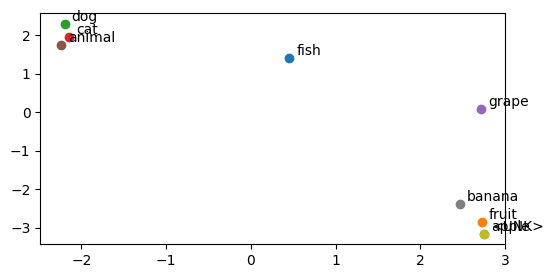

In [ ]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

In [ ]:
banana = get_embed('banana')
banana

(2.468825101852417, -2.3836357593536377)

In [ ]:
fruit = get_embed('fruit')
fruit

(2.7261922359466553, -2.8429956436157227)

In [ ]:
cat = get_embed('cat')
cat

(-2.141531467437744, 1.9536242485046387)

In [ ]:
np.array(banana) @ np.array(cat)

np.float64(-9.943795262293179)

In [ ]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(cat)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

-0.9995996105980994
0.9992580356807962
